<a href="https://colab.research.google.com/github/GParolini/colabs_am_bib/blob/master/Wang_Barger_data_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Content of the notebook

This notebook has been created to analyse the bibliographic data extracted from chapters 1-4 and 6-8 of Wang and Barger, *Bibliography of Agricultural Meteorology* (1962). The data used only refer to the period 1900-1950. Manual ETL with checks done as part of the project "Environmental Factors in Agriculture: Observation and Experiment in Agricultural Meteorology (ca 1900-1950)" (https://agriculturalmeteorology.wordpress.com).  The data analysis has been used in the preparation of an advanced review for the journal *WIREs Climate Change*. The data analysis work has been made possible with funding provided by the German Research Foundation (DFG), project No. 321660352.

#Module imports and styling of the notebook


In [1]:
from IPython.display import HTML, display

def set_css():
  display(HTML('''
  <style>
    pre {
        white-space: pre-wrap;
    }
  </style>
  '''))
get_ipython().events.register('pre_run_cell', set_css)

In [2]:
from google.colab import drive #to access data stored in Google drive
from google.colab import files #to save data in Google drive

import pandas as pd
import numpy as np
import matplotlib as mt
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import json
from collections import Counter
from collections import defaultdict
import glob
import re
from textwrap import wrap

import spacy.cli
from spacy.lang.en.stop_words import STOP_WORDS

from gensim import corpora
from gensim import models

from wordcloud import WordCloud

#Reading and cleaning data

In [3]:
"""
Data are stored in Google drive as csv file.
"""

drive.mount("/content/drive", force_remount=True) 

Mounted at /content/drive


In [4]:
df = pd.read_csv("/content/drive/My Drive/Wang_and_Barger.csv")

In [5]:
#Avoid that the year of publication is displayed as a float
df["Publication Year"] = (df["Publication Year"].fillna(0)
    .astype(int)
    .astype(object)
    .where(df["Publication Year"].notnull())
    )

#Remove columns with scarce information
df = df.loc[:, df.isnull().mean() <= .97]

#Remove column with uniteresting information
df =df.drop(["Date Added", "Date Modified"], axis=1)

In [6]:
df.head(5)

,Key,Item Type,Publication Year,Author,Title,Publication Title,DOI,Url,Date,Pages,Num Pages,Issue,Volume,Series,Publisher,Place,Language,Type,Archive,Number
0,PQLEU89J,book,1925,"Klein, P.; Sanson, J.",Météorologie et physique agricoles [Meteorolog...,NaN,NaN,https://catalog.hathitrust.org/Record/001998112,1925,NaN,464,NaN,NaN,Encyclopédie agricole,J. B. Baillière et fils,Paris,French,NaN,WB 00332,NaN
1,LVR77UMQ,journalArticle,1922,"Azzi, G.",The problem of agricultural ecology,Monthly Weather Review,10.1175/1520-0493(1922)50<193a:TPOAE>2.0.CO;2,https://journals.ametsoc.org/mwr/article/50/4/...,1922,193,NaN,4,50,NaN,NaN,NaN,English,NaN,WB 00004,NaN
2,CDN3ZEA2,journalArticle,1920,"Taylor, T. G.",Agricultural climatology of Australia,Quarterly Journal of the Royal Meteorological ...,10.1002/qj.49704619602,https://rmets.onlinelibrary.wiley.com/doi/abs/...,1920,331-356,NaN,196,46,NaN,NaN,NaN,English,NaN,WB 00216; WB 04808,NaN
3,EVIH66HB,journalArticle,1915,"Kincer, J. B.",A correlation of weather conditions and produc...,Monthly Weather Review,10.1175/1520-0493(1915)43<61:ACOWCA>2.0.CO;2,https://journals.ametsoc.org/doi/abs/10.1175/1...,1915,61-65,NaN,2,43,NaN,NaN,NaN,English,NaN,WB 00823,NaN
4,B8GM7Y7X,journalArticle,1919,"Kincer, J. B.",Relation between vegetative and frostless periods,Monthly Weather Review,10.1175/1520-0493(1919)47<106c:RBVAFP>2.0.CO;2,https://journals.ametsoc.org/doi/abs/10.1175/1...,1919,106-110,NaN,2,47,NaN,NaN,NaN,English,NaN,WB 02986,NaN


#Data inspection and visualisation

##Items

###Item types and count

In [7]:
item_types =list(set(df["Item Type"]))
print(item_types)

['report', 'bookSection', 'document', 'encyclopediaArticle', 'journalArticle', 'book', 'thesis']


In [8]:
count_item_types = df["Item Type"].value_counts()
print(count_item_types)

journalArticle         2747
report                  377
book                    225
bookSection             147
thesis                   48
document                  1
encyclopediaArticle       1
Name: Item Type, dtype: int64


###Items listed per type

###Journal articles


In [9]:
#Listing items per type helps in cleaning further the data (e.g. eliminate typos and inconsistencies in journal titles)

articles = df.loc[df["Item Type"] == "journalArticle"]
journ_titles = articles["Publication Title"].dropna()
journ_titles_unique = list(set(journ_titles))
sorted_journ_titles = sorted(journ_titles_unique)


with open('journal_titles_wb.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_journ_titles))


####Popular publication outlets (journals)

In [10]:
journals = sorted_journ_titles

my_list = []
no_art = df.loc[df["Item Type"] == "journalArticle"].groupby(["Publication Title"]).size()
my_dict = {k: v for k, v in zip(journals,no_art)}
my_dict1 = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)

with open('journal_art_dict_wb.json', 'w', encoding='utf-8') as f:
    json.dump(my_dict1, f, ensure_ascii=False, indent=2)

###Reports

In [11]:
reports = df.loc[df["Item Type"] == "report"]
rep_titles = reports["Type"].dropna()
rep_titles_unique = list(set(rep_titles))
sorted_rep_titles = sorted(rep_titles_unique)

with open('report_titles_wb.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_rep_titles))

###Books

In [12]:
books = df.loc[df["Item Type"] == "book"]
book_titles = books["Title"].dropna()
book_titles_unique = list(set(book_titles))
sorted_book_titles = sorted(book_titles_unique)

with open('book_titles_wb.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_book_titles))

###Book chapters

In [13]:
book_sections = df.loc[df["Item Type"] == "bookSection"]
book_sec_titles = book_sections["Publication Title"].dropna()
book_sec_titles_unique = list(set(book_sec_titles))
sorted_book_sec_titles = sorted(book_sec_titles_unique)

with open('book_sec_titles_wb.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_book_sec_titles))

###Theses

In [14]:
theses = df.loc[df["Item Type"] == "thesis"]
thesis_titles = theses["Title"].dropna()
thesis_titles_unique = list(set(thesis_titles))
sorted_thesis_titles = sorted(thesis_titles_unique)

with open('thesis_titles_wb.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(sorted_thesis_titles))

##Languages included in the data set and their popularity

In [15]:
lang_counts = df["Language"].value_counts()
print(lang_counts)

English         2619
German           249
French           164
Russian          144
Italian          112
Polish            84
Spanish           54
Japanese          46
Czechoslovak      23
Dutch             13
Portuguese         8
Hungarian          7
Swedish            5
Chinese            4
Greek              3
Norwegian          3
Portoguese         1
Hebrew             1
Turkish            1
Danish             1
Belorussian        1
Finnish            1
Ukranian           1
Albanian           1
Name: Language, dtype: int64


##Distribution of the publications over time

In [16]:
df["Publication Year"]=pd.to_numeric(df["Publication Year"])
years = [x for x in range (1900, 1951)]
no_publications = df.groupby(["Publication Year"]).size().tolist()
my_dict = {k: v for k, v in zip(years,no_publications)}
my_dict1 = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)

with open('years_dict_wb.json', 'w', encoding='utf-8') as f:
    json.dump(my_dict1, f, indent=2)


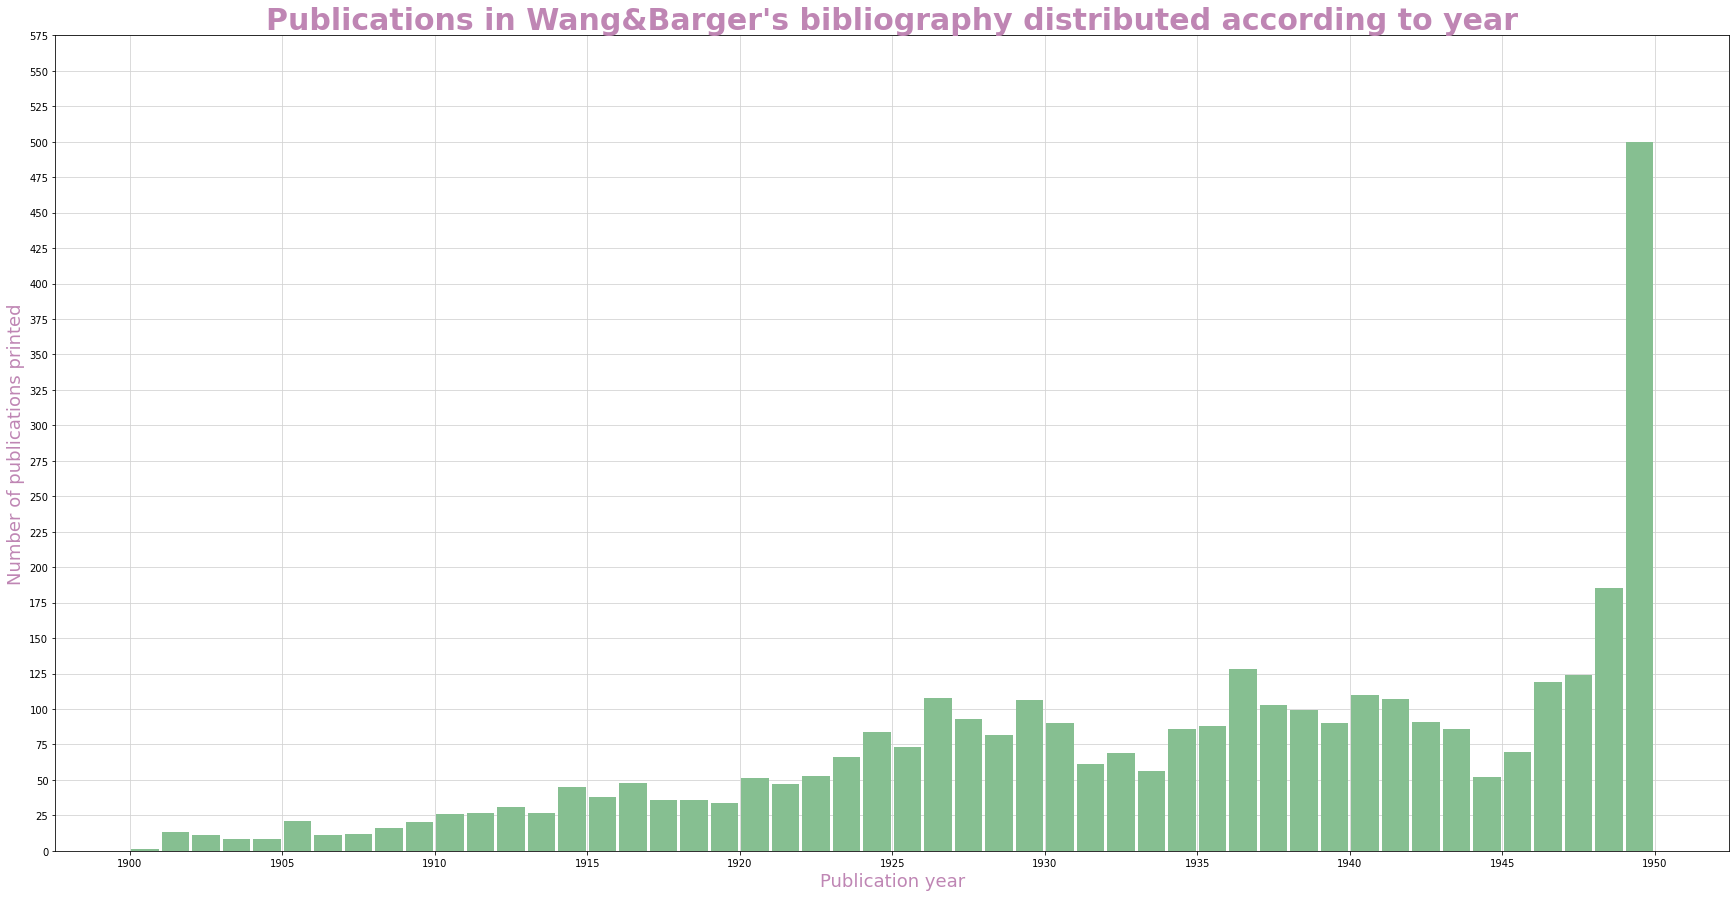

In [17]:
#histogram
ax = df.hist(column="Publication Year", bins=50, grid=False, figsize=(30,15), 
             color='#86bf91', zorder=2, rwidth=0.9)
#title
plt.title("Publications in Wang&Barger's bibliography distributed according to year",
          color="#bf86b4", fontdict = {'fontsize':30, "fontweight":"bold"})
#ticks
plt.xlabel('Publication year', fontsize=18, color ="#bf86b4")
plt.xticks(list(range(1900, 1955, 5))) 
plt.rc('xtick',labelsize=20, color ="#bf86b4")
plt.ylabel('Number of publications printed',
           fontsize=18, color ="#bf86b4" )
plt.yticks(list(range(0, 600, 25)))
plt.rc('ytick',labelsize=20, color ="#bf86b4")

#grid
plt.grid(True,color="#D3D3D3")

#save to file
plt.savefig("publications_per_year")

##Distribution of the publications per language

(-1.1125524975351226,
 1.1252172247475067,
 -1.214020787435373,
 1.106366818851802)

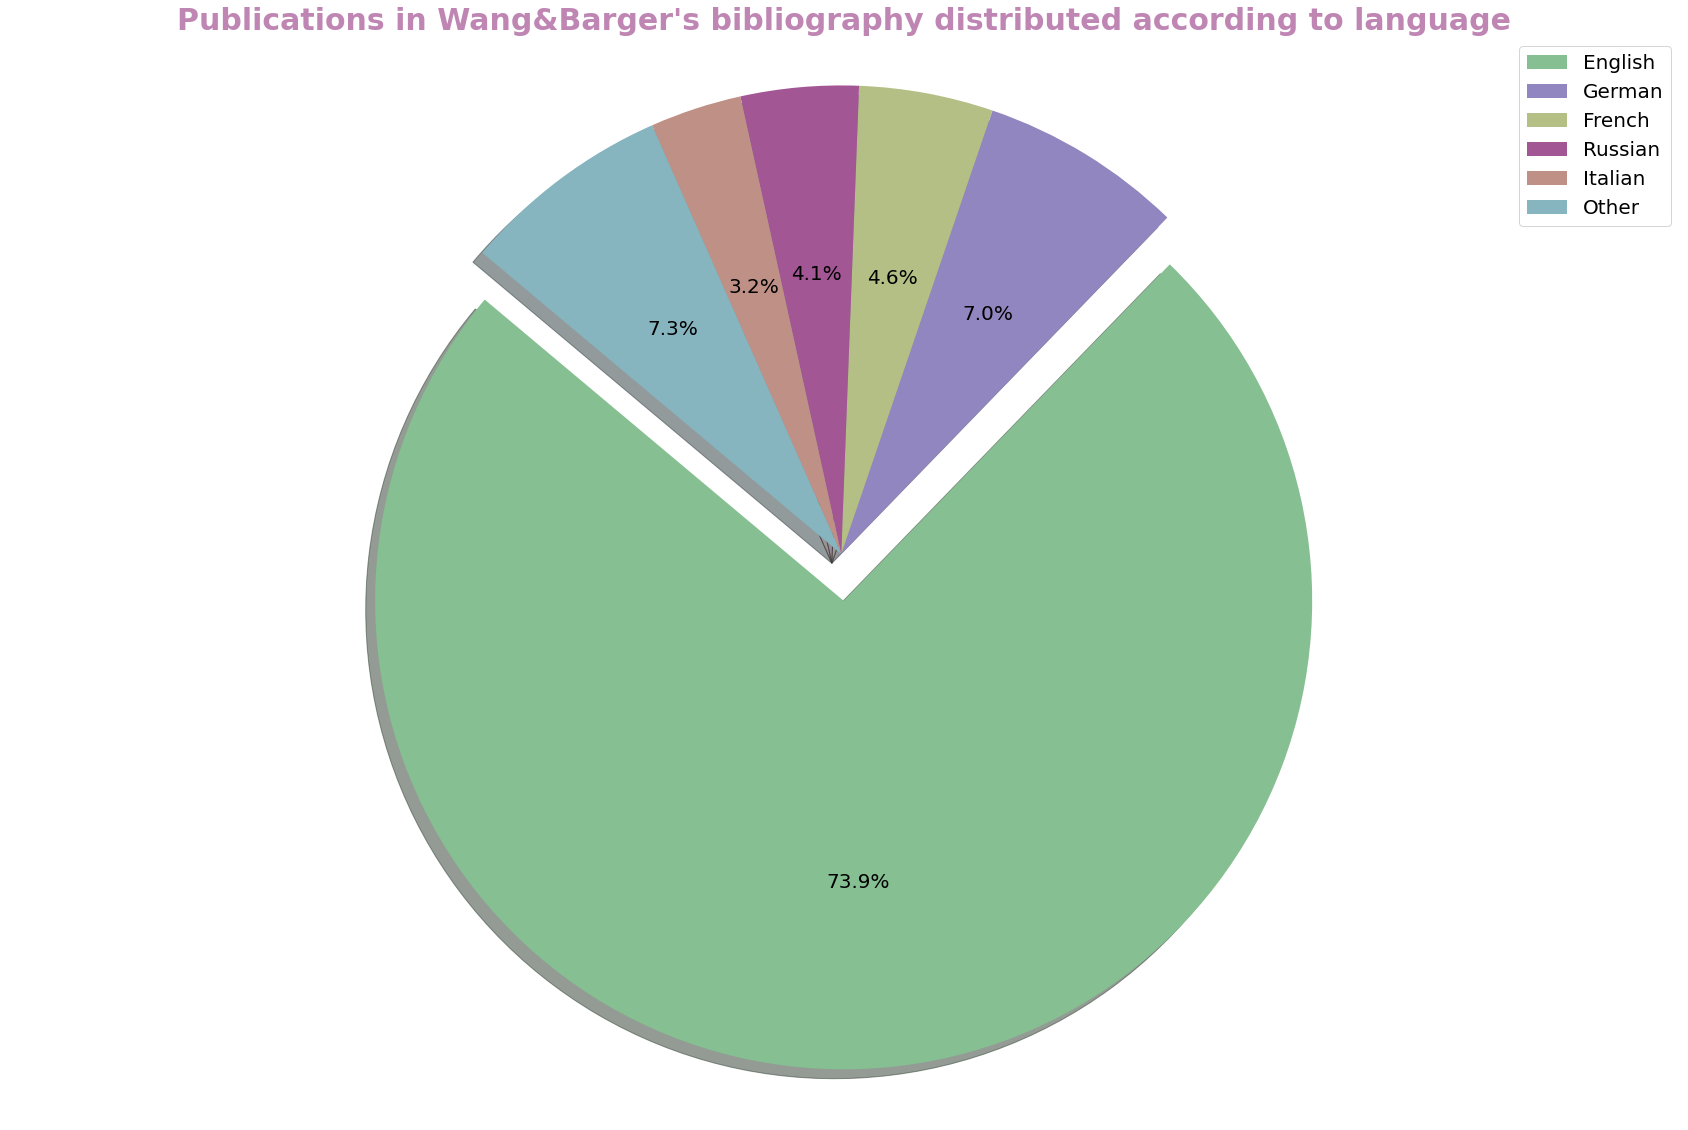

In [21]:
lang_list = sorted(list(set(df["Language"].tolist())))
lang_counts = df.groupby(["Language"]).size()
list_lang_counts = df.groupby(["Language"]).size().tolist()
my_dict = {k: v for k, v in zip(lang_list,list_lang_counts)}
my_dict1 = sorted(my_dict.items(), key=lambda x: x[1], reverse=True)
#my_dict1 is the dictionary that contains all the languages in the data set and the count of the publications in each language
with open('lang_dict_wb.json', 'w', encoding='utf-8') as f:
    json.dump(my_dict1, f, ensure_ascii=False, indent=2)

"""
There are over twenty languages in the dictionary, but only 5-6 can be displayed clearly in a pie chart.
For clarity's sake, therefore, I kept only the five main languages and grouped all the others
"""

list_main_lang = my_dict1[0:5]
list_other = my_dict1[5:]
other_count = []
for item in list_other:
  other_count.append(item[1])
other_sum = sum(other_count)
my_list_other = [("Other", other_sum)]
lang_list_pie_plot = list_main_lang + my_list_other

#generation of the pie chart
languages = [x[0] for x in lang_list_pie_plot]
counts = [x[1] for x in lang_list_pie_plot]
plt.figure(figsize=(30,20))      
explode = (0.1,0,0,0,0,0)
plt.pie(counts, explode, 
            autopct='%1.1f%%', shadow=True, startangle=140)
cmap = mcolors.ListedColormap(["#86bf91", "#9186bf", "#b4bf86", "#a35694", "#bf9186","#86b4bf"])
plt.cycler("color", cmap.colors)
plt.rcParams['axes.prop_cycle'] = plt.cycler('color',["#86bf91", "#9186bf", "#b4bf86", "#a35694", "#bf9186","#86b4bf"])
plt.rcParams['font.size'] = 20
plt.title("Publications in Wang&Barger's bibliography distributed according to language", 
          color="#bf86b4", fontdict = {'fontsize':30, "fontweight":"bold"})
plt.legend(loc="best", labels=languages )
plt.axis('equal')

##Complete list of authors cited in the bibliography

In [22]:
def get_all_authors(df):
    reshaped = \
    (df.set_index(df.columns.drop("Author",1).tolist())
    .Author.str.split('; ', expand=True)
    .stack()
    .reset_index()
    .rename(columns={0:'Author'})
    .loc[:, df.columns]
    )
    authors = reshaped["Author"].dropna()
    authors1 = authors.str.strip(" ")
    authors_noduplicates = list(set(authors1))
    return sorted(authors_noduplicates)

my_authors = get_all_authors(df)

with open('authors_wb.txt', mode='wt', encoding='utf-8') as f:
  f.write('\n'.join(my_authors))

###Number of publications for each author

In [24]:
def author_counts(df):
    reshaped = \
    (df.set_index(df.columns.drop("Author",1).tolist())
    .Author.str.split('; ', expand=True)
    .stack()
    .reset_index()
    .rename(columns={0:'Author'})
    .loc[:, df.columns])
    authors = reshaped["Author"].dropna()
    authors1 = authors.str.strip(" ")
    count = Counter(authors1)
    my_dict1 = sorted(count.items(), key=lambda x: x[1], reverse=True)
    
    return my_dict1

publications_per_author = author_counts(df)

with open('publications_per_author_wb.json', 'w', encoding='utf-8') as f:
    json.dump(publications_per_author, f, ensure_ascii=False, indent=2)


###Histogram of the publications per author

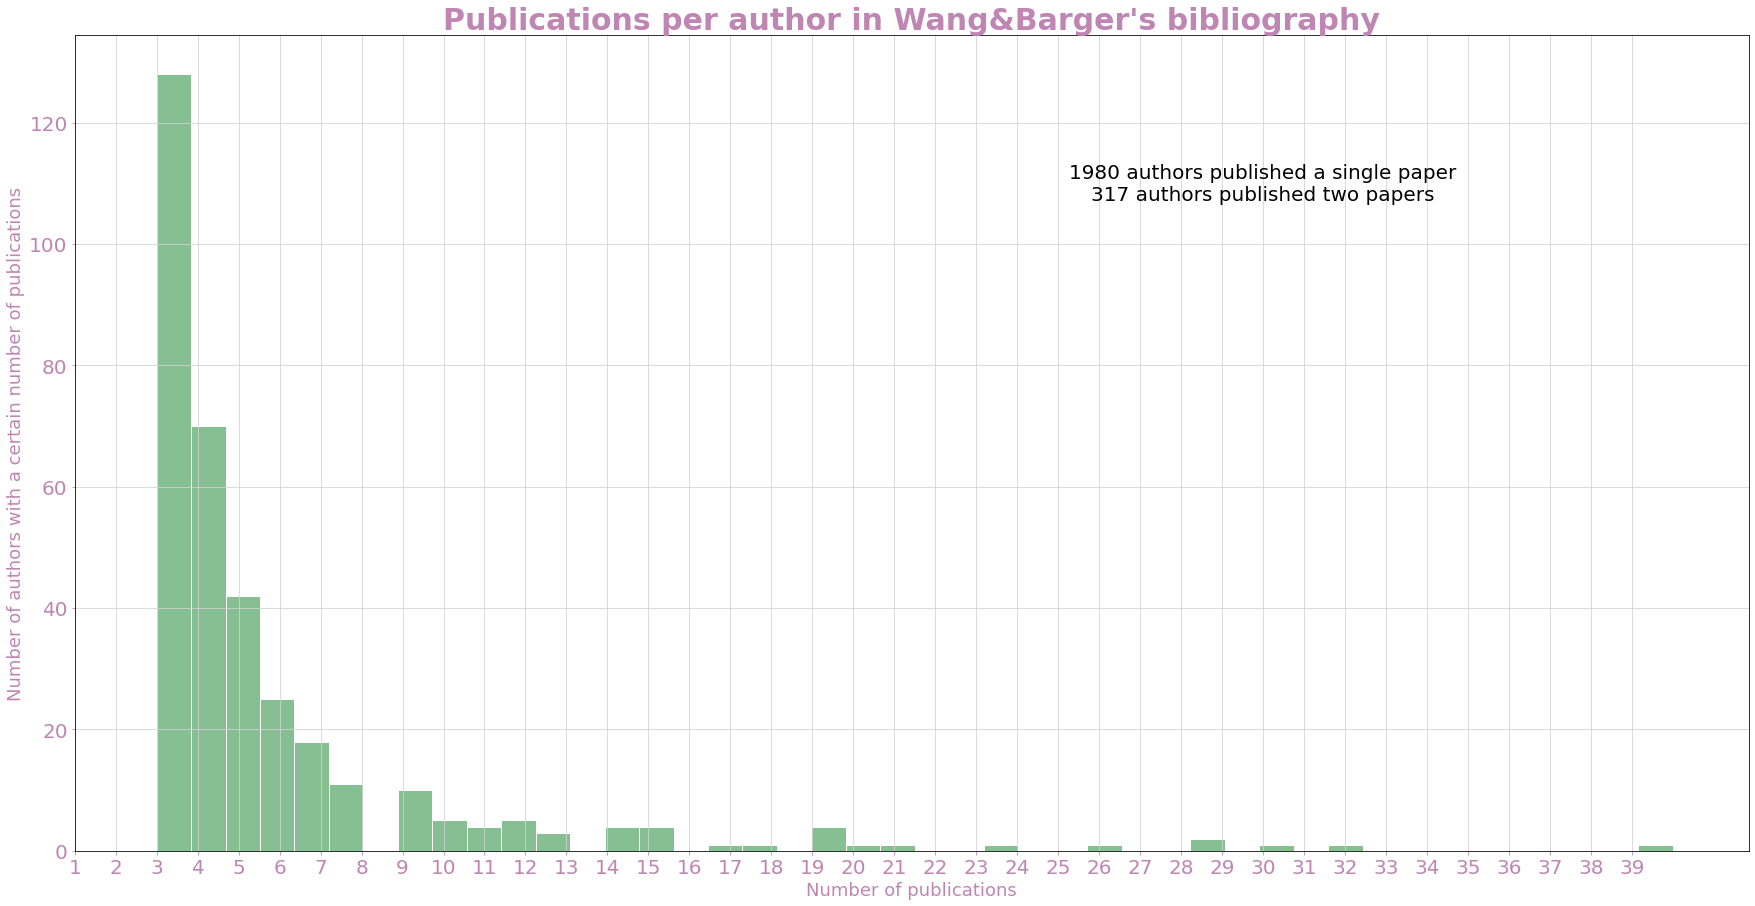

In [25]:
#No. of authors who published a single paper
my_list_1 = list(filter(lambda x: (x[1] == 1), publications_per_author))
counts_1 = []
for tup in my_list_1:
  counts_1.append(tup[1])
authors_1_papers =len(counts_1)

#No. of authors who published two papers
my_list_2 = list(filter(lambda x: (x[1] == 2), publications_per_author))
counts_2 = []
for tup in my_list_2:
  counts_2.append(tup[1])
authors_2_papers =len(counts_2)


my_list = list(filter(lambda x: (x[1] != 1) & (x[1] !=2), publications_per_author))
counts = []
for tup in my_list:
  counts.append(tup[1])

#histogram
plt.figure(figsize=(30,15))
ax = plt.hist(counts, bins='auto', color='#86bf91', edgecolor = 'white', label='hst')

#title
plt.title("Publications per author in Wang&Barger's bibliography",
          color="#bf86b4", fontdict = {'fontsize':30, "fontweight":"bold"})

#ticks
plt.xlabel('Number of publications', fontsize=18, color ="#bf86b4")
plt.xticks(list(range(1, 40, 1))) 
plt.rc('xtick',labelsize=20, color ="#bf86b4")
plt.ylabel('Number of authors with a certain number of publications',
           fontsize=18, color ="#bf86b4")
plt.yticks(list(range(0, 140, 20))) 
plt.rc('ytick',labelsize=20, color ="#bf86b4")

#grid
plt.grid(True,color="#D3D3D3")

#textbox
plt.text(30,110, str(authors_1_papers) + " authors published a single paper" + "\n" + str(authors_2_papers) + " authors published two papers", 
         horizontalalignment='center', verticalalignment='center')

#save to file
plt.savefig("publications_per_author")


##Themes

###Lemmas analysis with Spacy

In [26]:
#loading Spacy and its English model
spacy.cli.download("en_core_web_sm")
nlp = spacy.load("en_core_web_sm")
nlp.Defaults.stop_words |= {"=","inch","+","°","p.","possible","cent","c"}

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


In [27]:
#Get all the titles of the publications in English

eng_pub = df.loc[df['Language'] == 'English']

tit_eng_pub = list(eng_pub["Title"])

token_list = []
for item in tit_eng_pub:
  my_doc = nlp(item)
  for token in my_doc:
    token_list.append(token)

In [28]:
#Clean the tokens

for token in token_list:
    re.sub(r"[^a-zA-Z.!?]", "", str(token))
    re.sub(r"\d+", "", str(token))
    re.sub(r'\b\w{1,2}\b', '', str(token))

my_tokens_no_space = [token for token in token_list if token]
clean_tokens = [token for token in my_tokens_no_space if len(token)>2]


In [29]:
#Generate the lemmas from the tokens

lemmas = [token.lemma_ for token in clean_tokens]

stopwords = spacy.lang.en.stop_words.STOP_WORDS

#delete stopwords
my_lemmas_no_stopwords = [lemma for lemma in lemmas if lemma not in stopwords]

#delete pronouns
my_lemmas_no_pron = [lemma for lemma in my_lemmas_no_stopwords if lemma != '-PRON-']

In [30]:
#Counting the lemmas

lemma_counts = Counter(my_lemmas_no_pron)
lemma_dict = sorted(lemma_counts.items(), key=lambda x: x[1], reverse=True)

with open('lemmas_wb.json', 'w', encoding='utf-8') as f:
    json.dump(lemma_dict, f, ensure_ascii=False, indent=2)

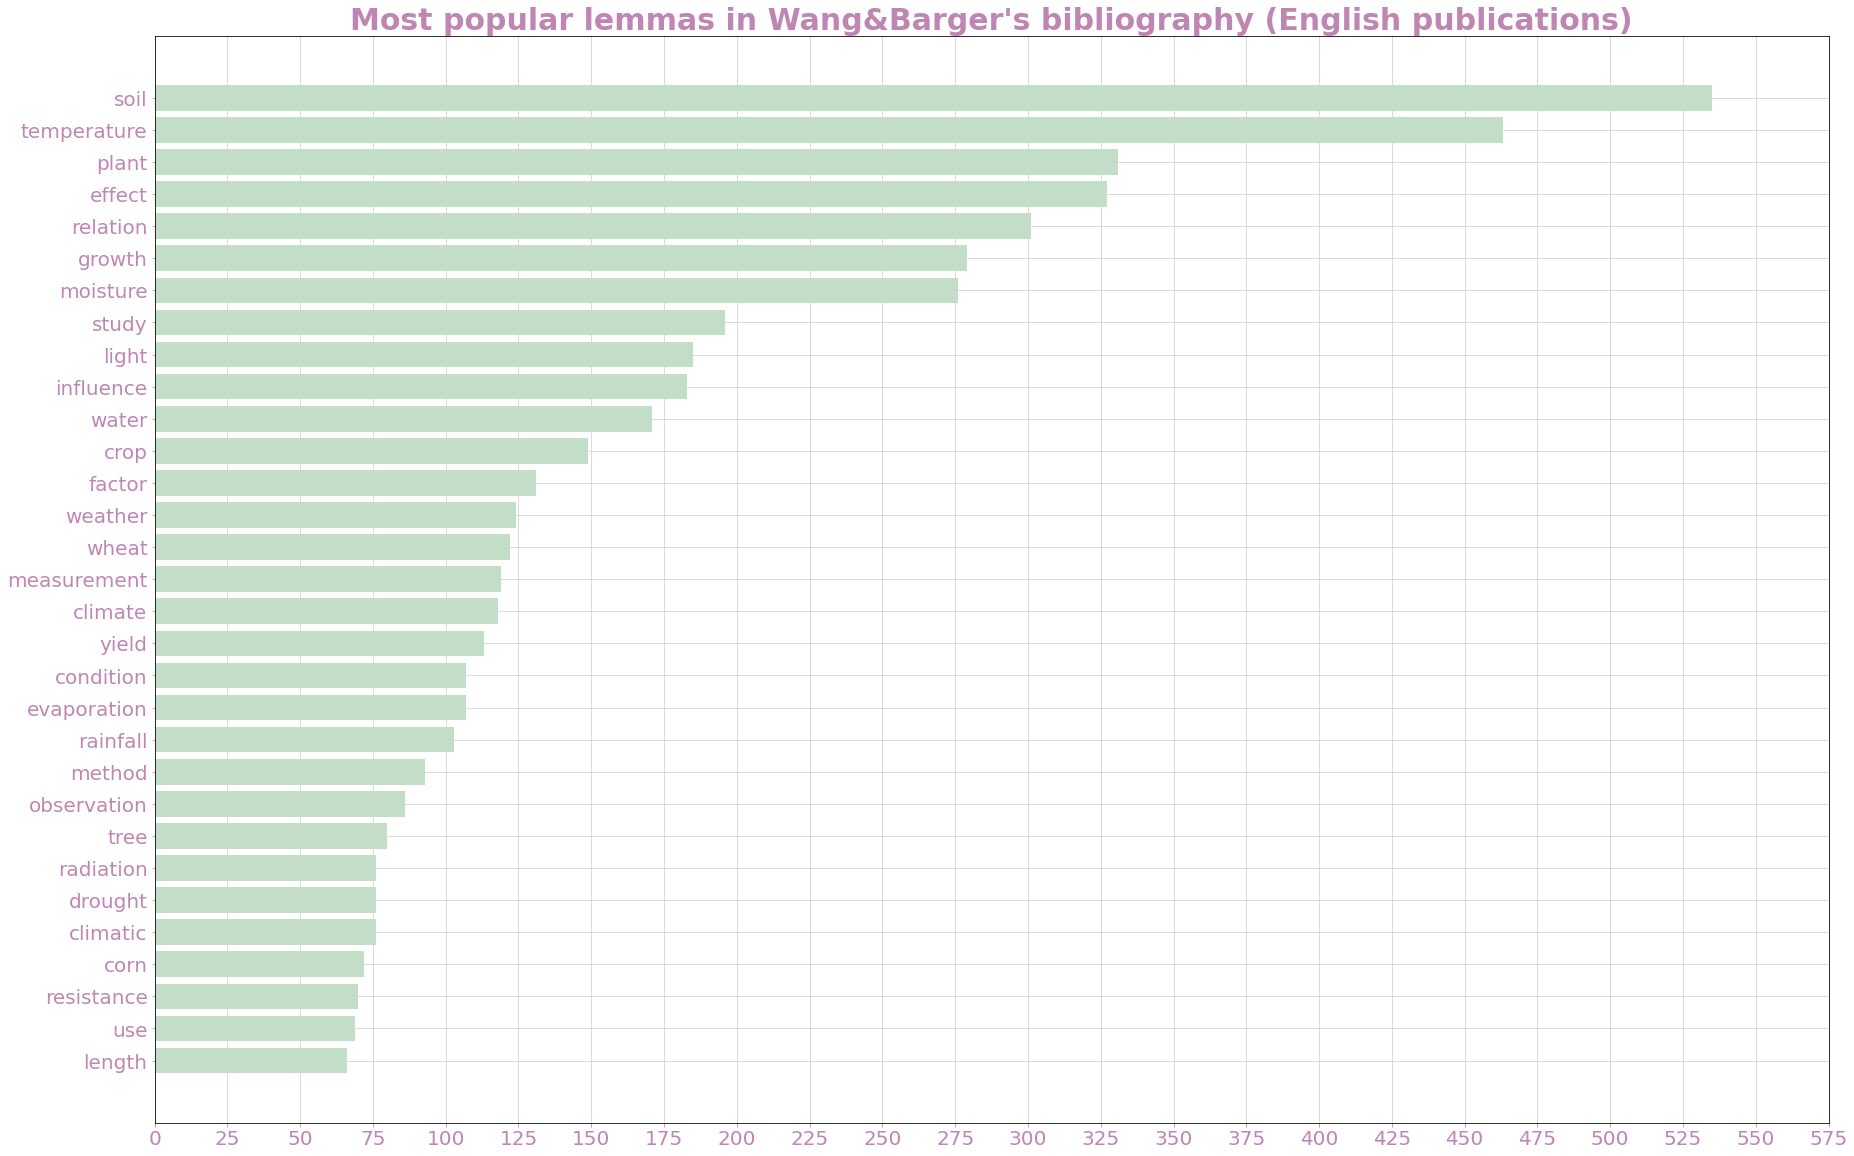

In [31]:
#Visualising the most popular lemmas

pop_lemma_dict = lemma_dict[0:31]

lemmas = [x[0] for x in pop_lemma_dict]
counts = [x[1] for x in pop_lemma_dict]

my_lemmas_uniq = list(set(my_lemmas_no_pron))

#bar plot
plt.figure(figsize=(30,20))
plt.barh(lemmas, counts, align='center', alpha=0.5, color='#86bf91')
plt.gca().invert_yaxis()

#title
plt.title("Most popular lemmas in Wang&Barger's bibliography (English publications)",
          color="#bf86b4", fontdict = {'fontsize':30, "fontweight":"bold"})

#grid
plt.grid(True,color="#D3D3D3")

#ticks
plt.rc('xtick',labelsize=20, color ="#bf86b4")
plt.rc('ytick',labelsize=20, color ="#bf86b4")
plt.xticks(list(range(0, 600, 25)))

#save to file
plt.savefig("popular_lemmas_wb")



###Topic analysis with Gensim

In [32]:
"""
Tentative topic modelling with Gensim.
Data are too few to consider the results more than a rough approssimation
"""

tokens_list = [lemma for lemma in lemmas if lemma not in stopwords]
texts = [token.split() for token in tokens_list]
dictionary = corpora.Dictionary(texts)
corpus = [dictionary.doc2bow(text) for text in texts]


model = models.ldamodel.LdaModel(corpus, num_topics=4, id2word=dictionary, passes=15)
 
topics = model.print_topics(num_words=6)
for topic in topics:
    print(topic)

(0, '0.085*"relation" + 0.085*"method" + 0.085*"effect" + 0.085*"study" + 0.085*"wheat" + 0.085*"measurement"')
(1, '0.085*"influence" + 0.085*"radiation" + 0.085*"drought" + 0.085*"moisture" + 0.085*"resistance" + 0.085*"light"')
(2, '0.070*"corn" + 0.070*"water" + 0.070*"factor" + 0.070*"weather" + 0.070*"condition" + 0.070*"yield"')
(3, '0.085*"climatic" + 0.085*"climate" + 0.085*"use" + 0.085*"observation" + 0.085*"growth" + 0.085*"temperature"')


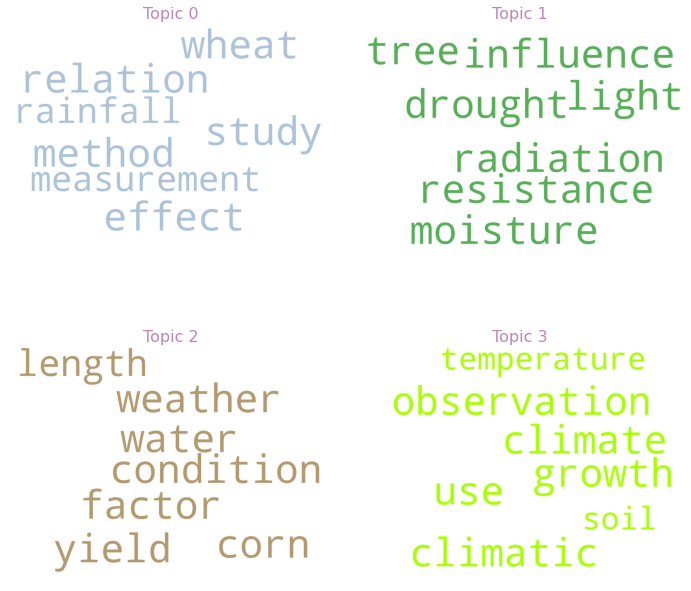

In [33]:
#Generation of wordclouds for each topic

cols = [color for name, color in mcolors.XKCD_COLORS.items()]

cloud = WordCloud(
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=7,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = model.show_topics(formatted=False)

fig, axes = plt.subplots(2, 2, figsize=(10,10), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16), color="#bf86b4")
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()

#save to file
plt.savefig("word_clouds_topics_wb")